# IMPORTS

In [1]:
from utils import *
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import matplotlib.pyplot as plt

from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer



## 1- Read Dataset

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns


## Uncomment to read the dataset online

In [3]:

#!pip install ucimlrepo
# from ucimlrepo import fetch_ucirepo 
  
# # fetch dataset 
# phiusiil_phishing_url_website = fetch_ucirepo(id=967) 
  
# # data (as pandas dataframes) 
# X = phiusiil_phishing_url_website.data.features 
# y = phiusiil_phishing_url_website.data.targets 
  
# # metadata 
# print(phiusiil_phishing_url_website.metadata) 
  
# # variable information 
# print(phiusiil_phishing_url_website.variables) 


## 2- Preprocessing & Visualization

In [4]:
# load the dataset
DATASET_PATH = "./dataset/PhiUSIIL_Phishing_URL_Dataset.csv"


In [5]:
# find spark
spark = SparkSession.builder.appName("PhishingURL").getOrCreate()
sc = spark.sparkContext


In [6]:
# read dataset
phishing_rdd = spark.read.csv(DATASET_PATH, header=True, inferSchema=True)

In [7]:
# show rdd header and first 10 rows
phishing_rdd.show(10)

+----------+--------------------+---------+--------------------+------------+----------+---+------------------+--------------------+-----------------+-----------+---------+-------------+--------------+------------------+----------------+----------------+----------------+---------------+---------------+---------------+--------------+------------------+--------------------------+---------------------+-------+----------+-----------------+--------+--------------------+---------------------+------------------+----------+------+------------+---------------+----------------+--------------+---------+----------+---------------------+------------+---------------+---------------+----------------+----+---+------+----------------+---------+-------+------+-----------+------------+---------------+-----+
|  FILENAME|                 URL|URLLength|              Domain|DomainLength|IsDomainIP|TLD|URLSimilarityIndex|CharContinuationRate|TLDLegitimateProb|URLCharProb|TLDLength|NoOfSubDomain|HasObfuscation

In [8]:
# drop filename column since it's not relevant
phishing_rdd = phishing_rdd.drop("filename")


In [9]:
# show rows, columns, and schema
print("Rows: ", phishing_rdd.count())
print("Columns: ", len(phishing_rdd.columns))
print("Schema: ", phishing_rdd.printSchema())

Rows:  235795
Columns:  55
root
 |-- URL: string (nullable = true)
 |-- URLLength: integer (nullable = true)
 |-- Domain: string (nullable = true)
 |-- DomainLength: integer (nullable = true)
 |-- IsDomainIP: integer (nullable = true)
 |-- TLD: string (nullable = true)
 |-- URLSimilarityIndex: double (nullable = true)
 |-- CharContinuationRate: double (nullable = true)
 |-- TLDLegitimateProb: double (nullable = true)
 |-- URLCharProb: double (nullable = true)
 |-- TLDLength: integer (nullable = true)
 |-- NoOfSubDomain: integer (nullable = true)
 |-- HasObfuscation: integer (nullable = true)
 |-- NoOfObfuscatedChar: integer (nullable = true)
 |-- ObfuscationRatio: double (nullable = true)
 |-- NoOfLettersInURL: integer (nullable = true)
 |-- LetterRatioInURL: double (nullable = true)
 |-- NoOfDegitsInURL: integer (nullable = true)
 |-- DegitRatioInURL: double (nullable = true)
 |-- NoOfEqualsInURL: integer (nullable = true)
 |-- NoOfQMarkInURL: integer (nullable = true)
 |-- NoOfAmpers

In [10]:
# check the number of missing values in each column
print("Missing values: ")
for col in phishing_rdd.columns:
    print(col, ":", phishing_rdd.where(phishing_rdd[col].isNull()).count())
    

Missing values: 
URL : 0
URLLength : 0
Domain : 0
DomainLength : 0
IsDomainIP : 0
TLD : 0
URLSimilarityIndex : 0
CharContinuationRate : 0
TLDLegitimateProb : 0
URLCharProb : 0
TLDLength : 0
NoOfSubDomain : 0
HasObfuscation : 0
NoOfObfuscatedChar : 0
ObfuscationRatio : 0
NoOfLettersInURL : 0
LetterRatioInURL : 0
NoOfDegitsInURL : 0
DegitRatioInURL : 0
NoOfEqualsInURL : 0
NoOfQMarkInURL : 0
NoOfAmpersandInURL : 0
NoOfOtherSpecialCharsInURL : 0
SpacialCharRatioInURL : 0
IsHTTPS : 0
LineOfCode : 0
LargestLineLength : 0
HasTitle : 0
Title : 0
DomainTitleMatchScore : 0
URLTitleMatchScore : 0
HasFavicon : 0
Robots : 0
IsResponsive : 0
NoOfURLRedirect : 0
NoOfSelfRedirect : 0
HasDescription : 0
NoOfPopup : 0
NoOfiFrame : 0
HasExternalFormSubmit : 0
HasSocialNet : 0
HasSubmitButton : 0
HasHiddenFields : 0
HasPasswordField : 0
Bank : 0
Pay : 0
Crypto : 0
HasCopyrightInfo : 0
NoOfImage : 0
NoOfCSS : 0
NoOfJS : 0
NoOfSelfRef : 0
NoOfEmptyRef : 0
NoOfExternalRef : 0
label : 0


In [11]:
# keep thee unique values of the url column
unique_urls = phishing_rdd.select("url").distinct()
print("Unique URLs: ", unique_urls.count())
filtered_rdd = phishing_rdd.dropDuplicates(["url"])

Unique URLs:  235370


In [12]:
#drop NON-informative columns 
filtered_rdd=filtered_rdd.drop("Domain")
filtered_rdd=filtered_rdd.drop("DomainLength")
filtered_rdd=filtered_rdd.drop("IsDomainIP")
filtered_rdd=filtered_rdd.drop("HasObfuscation")
filtered_rdd=filtered_rdd.drop("NoOfObfuscatedChar")
filtered_rdd=filtered_rdd.drop("ObfuscationRatio")
filtered_rdd=filtered_rdd.drop("Title")


In [13]:
print(filtered_rdd.count())
filtered_rdd.columns

235370


['URL',
 'URLLength',
 'TLD',
 'URLSimilarityIndex',
 'CharContinuationRate',
 'TLDLegitimateProb',
 'URLCharProb',
 'TLDLength',
 'NoOfSubDomain',
 'NoOfLettersInURL',
 'LetterRatioInURL',
 'NoOfDegitsInURL',
 'DegitRatioInURL',
 'NoOfEqualsInURL',
 'NoOfQMarkInURL',
 'NoOfAmpersandInURL',
 'NoOfOtherSpecialCharsInURL',
 'SpacialCharRatioInURL',
 'IsHTTPS',
 'LineOfCode',
 'LargestLineLength',
 'HasTitle',
 'DomainTitleMatchScore',
 'URLTitleMatchScore',
 'HasFavicon',
 'Robots',
 'IsResponsive',
 'NoOfURLRedirect',
 'NoOfSelfRedirect',
 'HasDescription',
 'NoOfPopup',
 'NoOfiFrame',
 'HasExternalFormSubmit',
 'HasSocialNet',
 'HasSubmitButton',
 'HasHiddenFields',
 'HasPasswordField',
 'Bank',
 'Pay',
 'Crypto',
 'HasCopyrightInfo',
 'NoOfImage',
 'NoOfCSS',
 'NoOfJS',
 'NoOfSelfRef',
 'NoOfEmptyRef',
 'NoOfExternalRef',
 'label']

In [14]:
##one HOT Encoding for categorial feauters

# Indexing the categorical column
string_indexer = StringIndexer(inputCol="TLD", outputCol="TLD" + "_index")

# Applying one-hot encoding
encoder = OneHotEncoder(inputCols=["TLD" + "_index"], outputCols=["TLD_Encoded"])

# Define the pipeline
pipeline = Pipeline(stages=[string_indexer, encoder])

# Fit the pipeline to the data
pipeline_model = pipeline.fit(filtered_rdd)

# Transform the data
df_encoded = pipeline_model.transform(filtered_rdd)

print(df_encoded.count())

# Show the result
df_encoded.show(10)

235370
+--------------------+---------+---+------------------+--------------------+-----------------+-----------+---------+-------------+----------------+----------------+---------------+---------------+---------------+--------------+------------------+--------------------------+---------------------+-------+----------+-----------------+--------+---------------------+------------------+----------+------+------------+---------------+----------------+--------------+---------+----------+---------------------+------------+---------------+---------------+----------------+----+---+------+----------------+---------+-------+------+-----------+------------+---------------+-----+---------+-----------------+
|                 URL|URLLength|TLD|URLSimilarityIndex|CharContinuationRate|TLDLegitimateProb|URLCharProb|TLDLength|NoOfSubDomain|NoOfLettersInURL|LetterRatioInURL|NoOfDegitsInURL|DegitRatioInURL|NoOfEqualsInURL|NoOfQMarkInURL|NoOfAmpersandInURL|NoOfOtherSpecialCharsInURL|SpacialCharRatioInUR

data Spiliting

In [15]:
df_train, df_test = df_encoded.randomSplit([0.75, 0.25], seed=42)


# generate descriptive statistics
filtered_rdd.describe().show()


In [16]:
# split the dataset into the rows that are real and phishing based on the label column
# where 1 is phishing and 0 is real
all_legitimate_rdd = filtered_rdd.where(filtered_rdd["label"] == 0)
all_phishing_rdd = filtered_rdd.where(filtered_rdd["label"] == 1)

In [17]:
# show the number of the legitimate and phishing URLs
print("Legitimate URLs: ", all_legitimate_rdd.count())
print("Phishing URLs: ", all_phishing_rdd.count())


Legitimate URLs:  100520
Phishing URLs:  134850


In [18]:
# # show histograms for integer columns in the dataset to understand the distribution of the data


# # convert the rdd to a pandas dataframe
# phishing_df = phishing_rdd.toPandas()

# # plot histograms for integer columns
# for col in phishing_df.select_dtypes(include=["int"]).columns:
#     sns.histplot(phishing_df[col])
#     plt.title(col)
#     plt.show()
    

In [19]:
# Compute descriptive statistics for numeric columns
numeric_cols = [col for col, dtype in df_train.dtypes if dtype == 'int' or dtype == 'double']
numeric_stats = df_train.select(numeric_cols).describe().toPandas()

print(numeric_stats)

  summary           URLLength URLSimilarityIndex CharContinuationRate  \
0   count              176759             176759               176759   
1    mean    34.5864029554365  78.46449233067126   0.8457878598836689   
2  stddev  42.465217769886124  28.94706081901068  0.21634405665013826   
3     min                  13        0.155574352                  0.0   
4     max                6097              100.0                  1.0   

     TLDLegitimateProb           URLCharProb           TLDLength  \
0               176759                176759              176759   
1   0.2604485919766957   0.05574548830367349  2.7639893866790377   
2  0.25162983164258623  0.010584024427173796  0.5984254698294276   
3                  0.0           0.001082764                   2   
4            0.5229071           0.090823664                  13   

        NoOfSubDomain    NoOfLettersInURL     LetterRatioInURL  ...  \
0              176759              176759               176759  ...   
1  1.16448

In [22]:

# Define the list of columns to plot against the label column, excluding columns with URLs
columns_to_plot = [col for col in df_train.columns if col != 'label' and not col.startswith('http')]

# Convert Spark DataFrame to Pandas DataFrame for plotting




#sample_data=df_train.sample(fraction=0.1,seed=42)
pandas_df = df_train.select(*columns_to_plot,'label').toPandas()



ValueError: 
https://lps.arlbrg-medias.com/vfos_clc_es_gt_x/?coc=ld_gt_dv360sk_2453_bn&amp;utm_campaign=ios&amp;site=$%7bsource_url%7d&amp;io=$%7binsertion_order_id%7d&amp;creative=$%7bcreative_id%7d&amp;li=$%7bcampaign_id%7d&amp;cpid=63feb9e4-7237-431a-9b5e-95f340b34c0a&amp;oid=722d7943-f712-4b58-aa6a-504b4e079198&amp;wbraid=clikcqia5nsdbhcyarjbahgxh30jvljv98bgh3gvry3bzimp3xrcmbhiz-ljk9ch6bsdl4lamcys0aty6bof-hzefzmdvwz_zz7ki8oztruaagel
                                                                                                        ^
Expected end of text, found '$'  (at char 104), (line:1, col:105)

<Figure size 800x600 with 1 Axes>

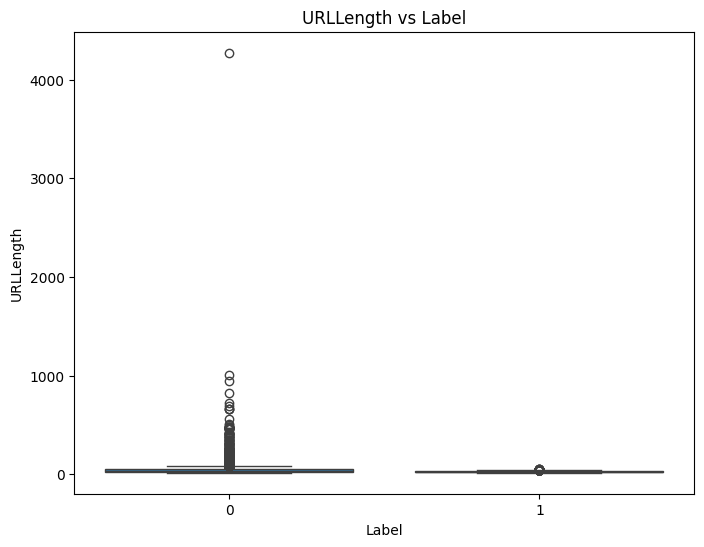

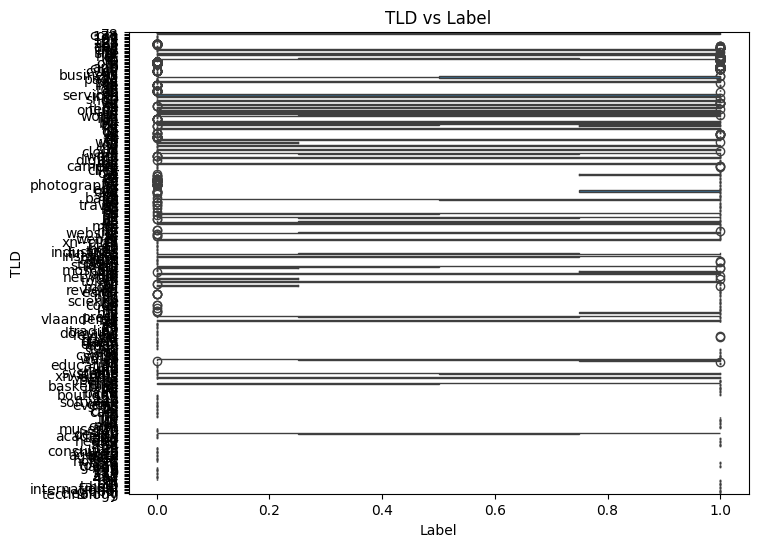

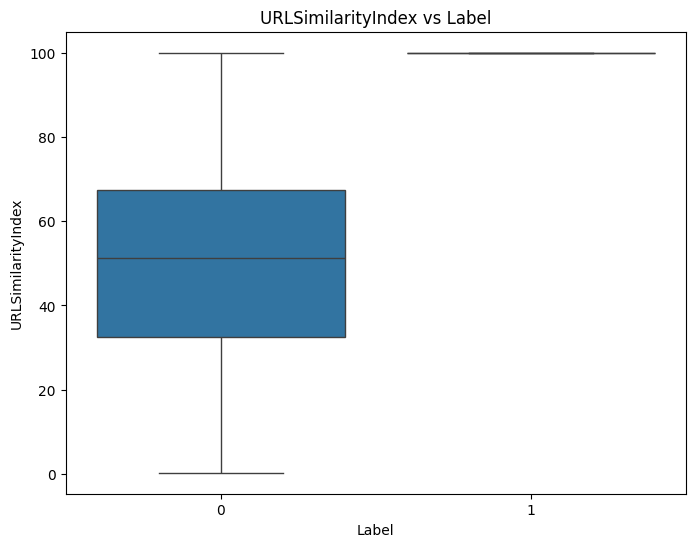

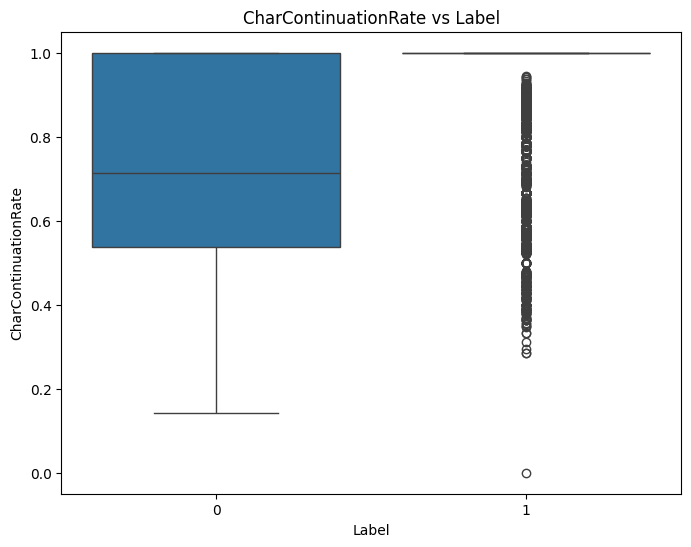

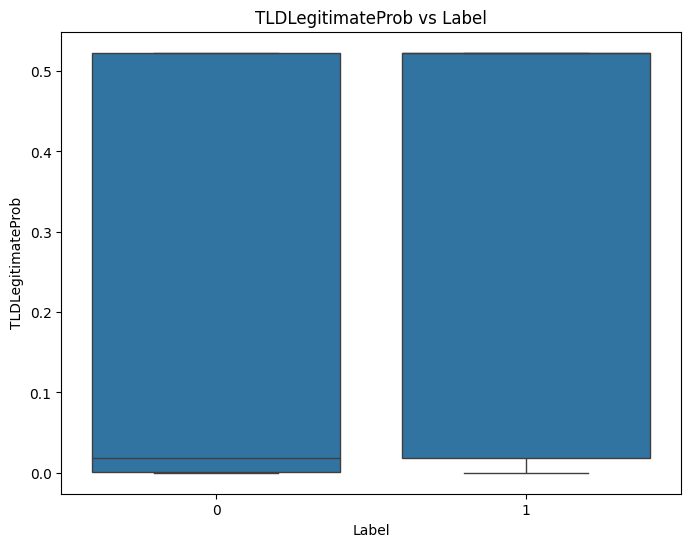

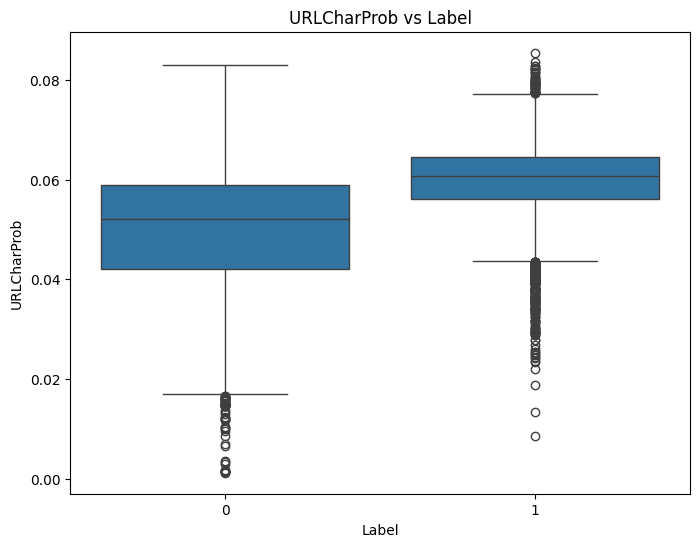

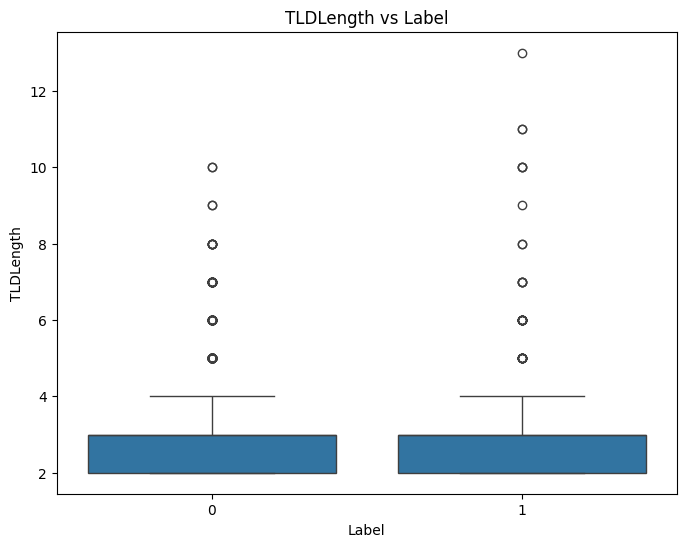

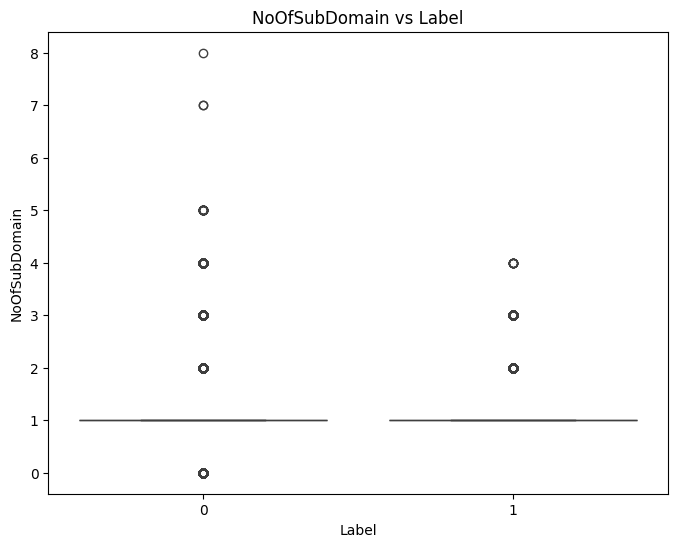

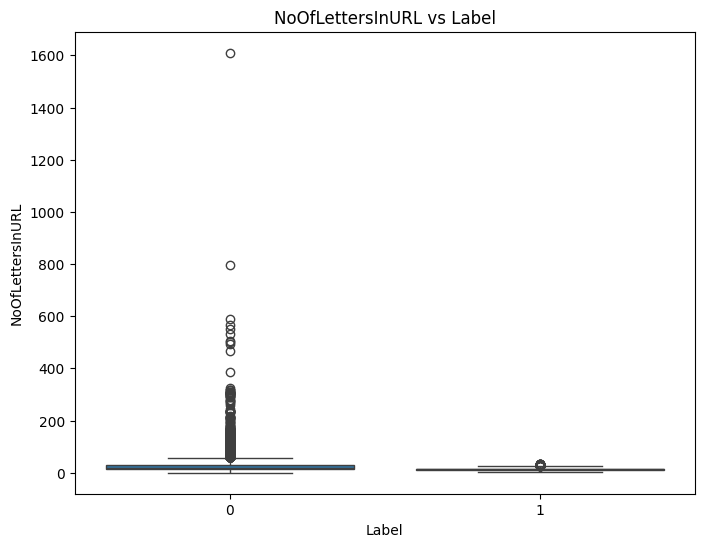

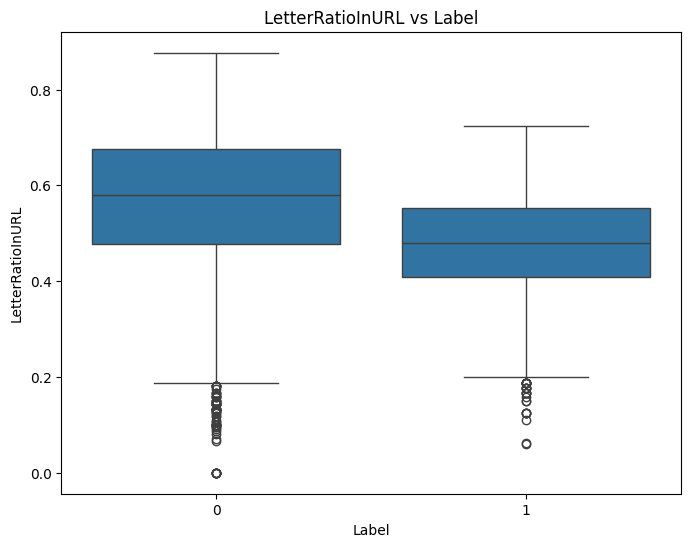

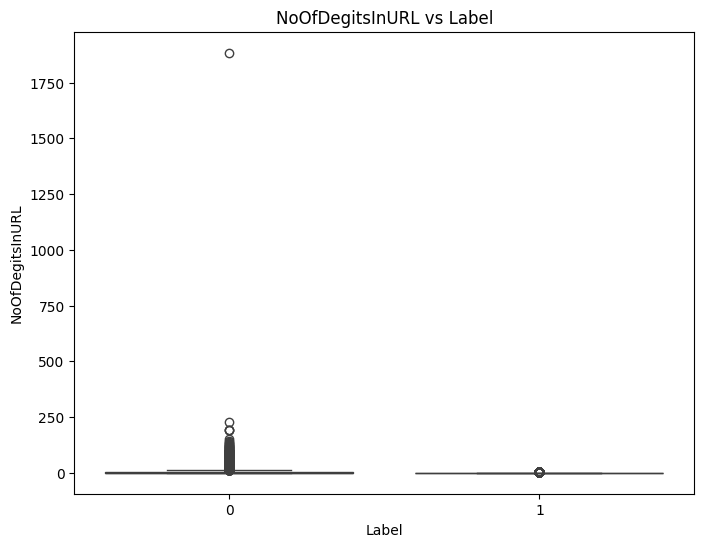

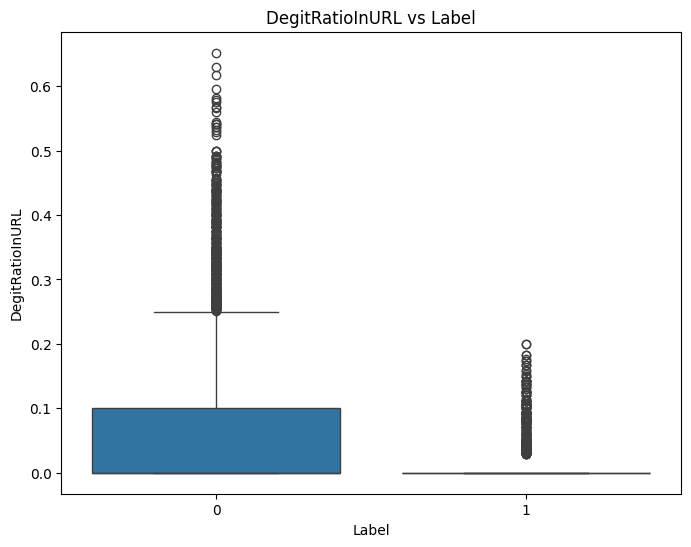

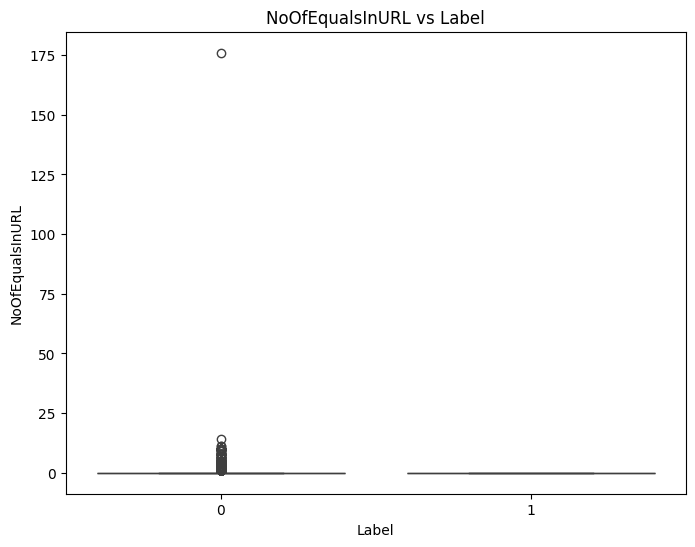

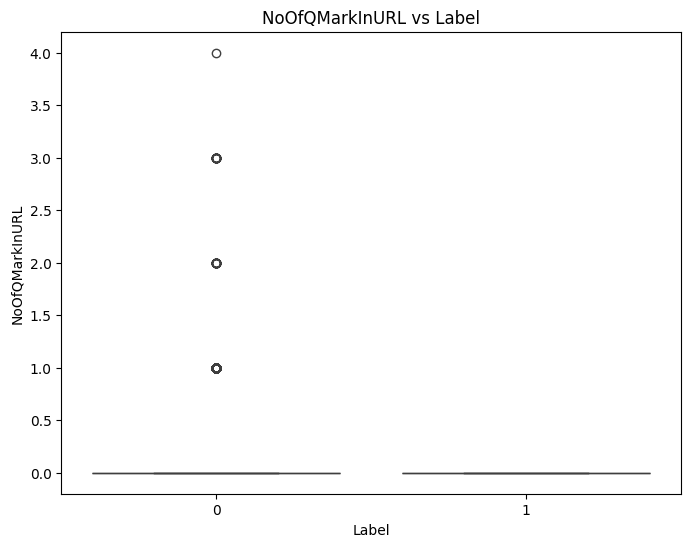

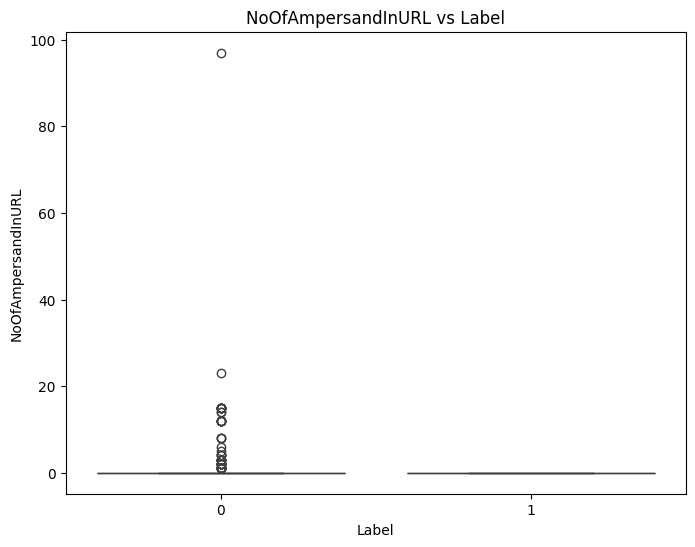

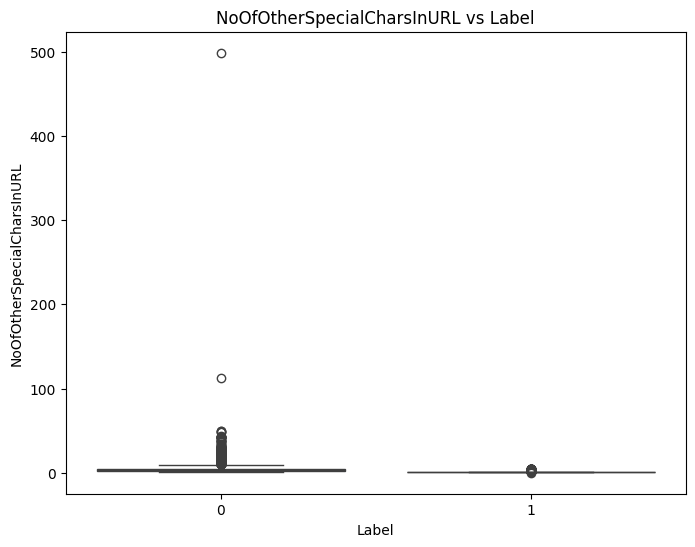

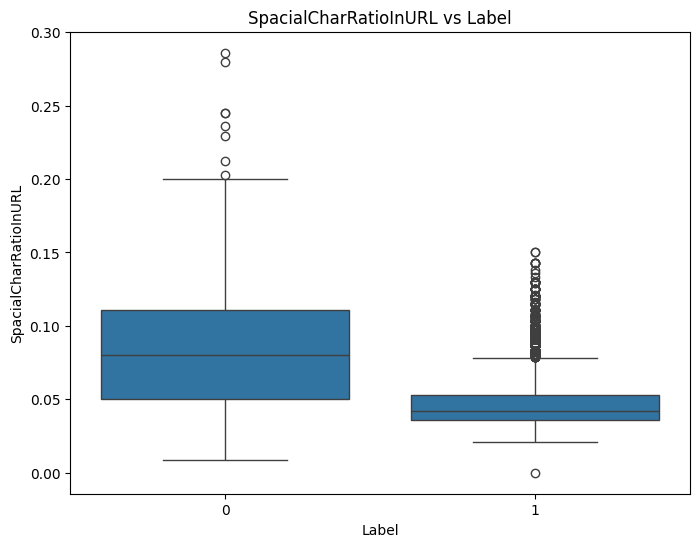

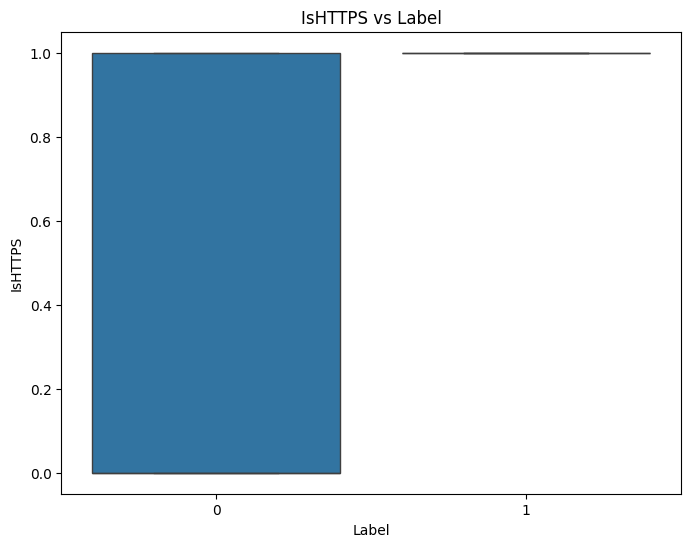

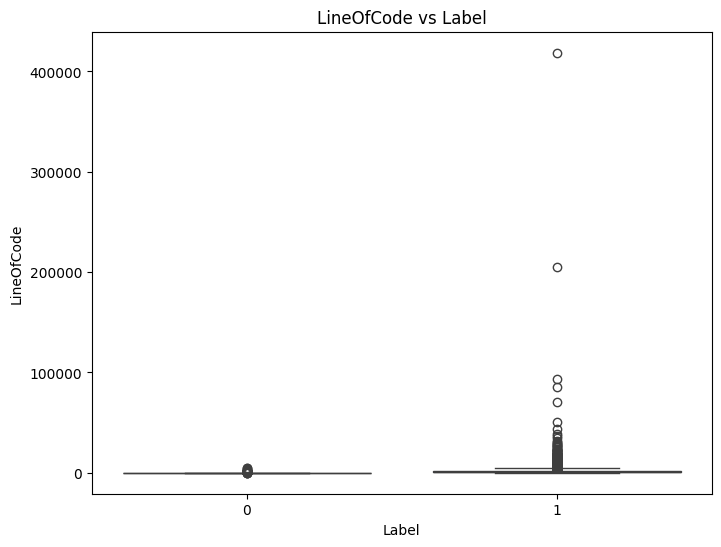

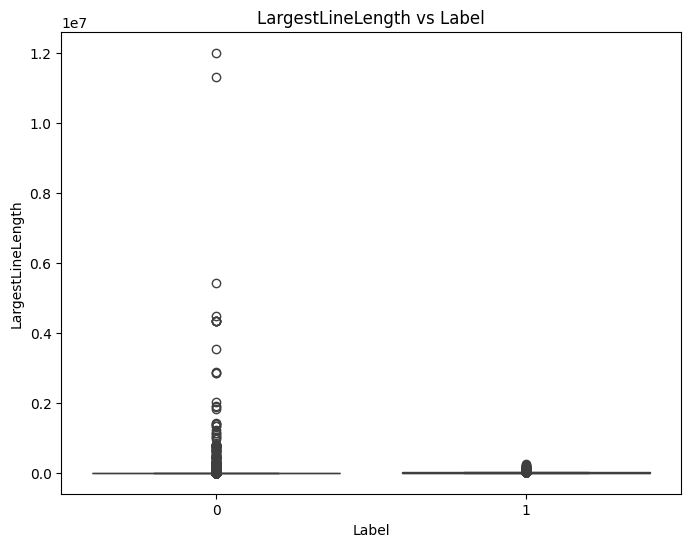

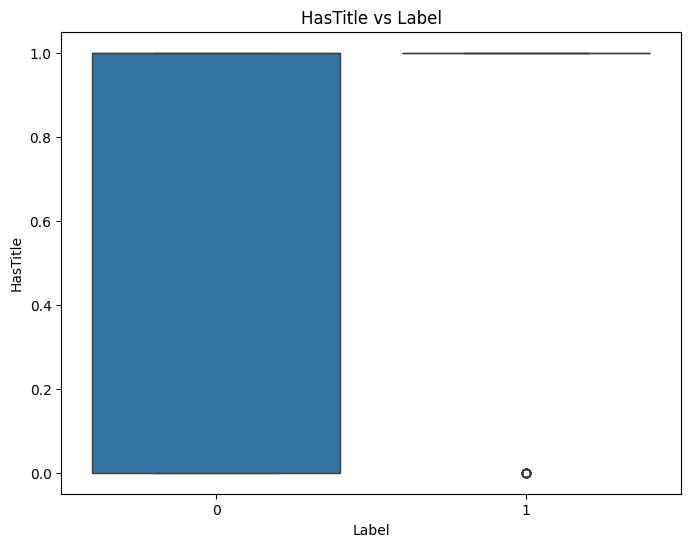

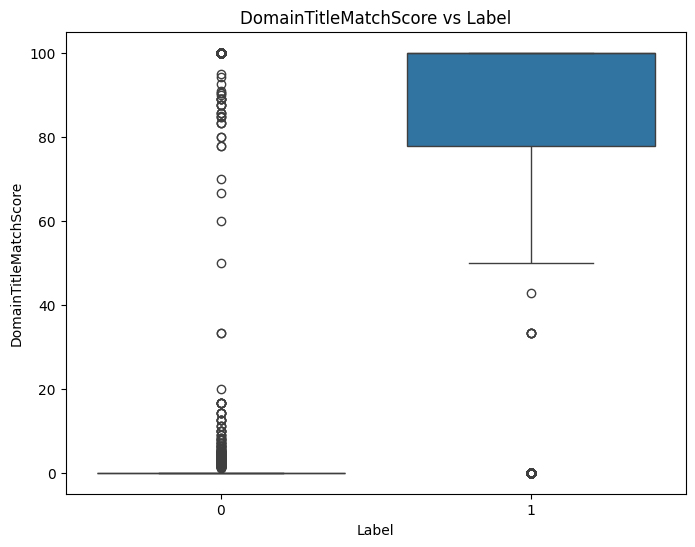

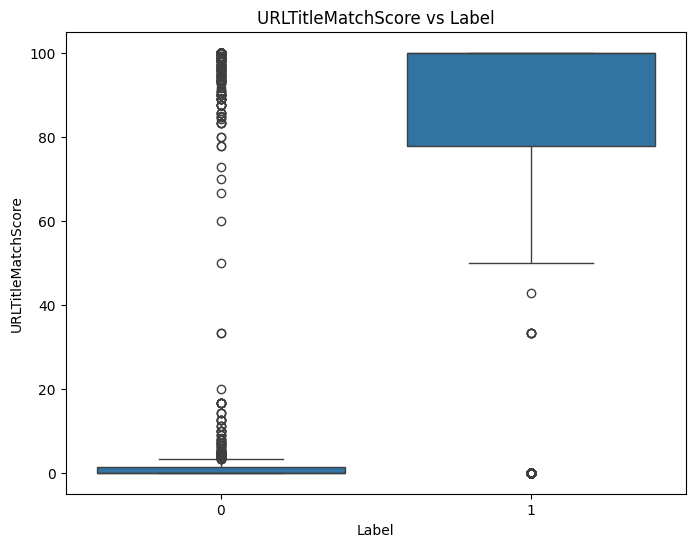

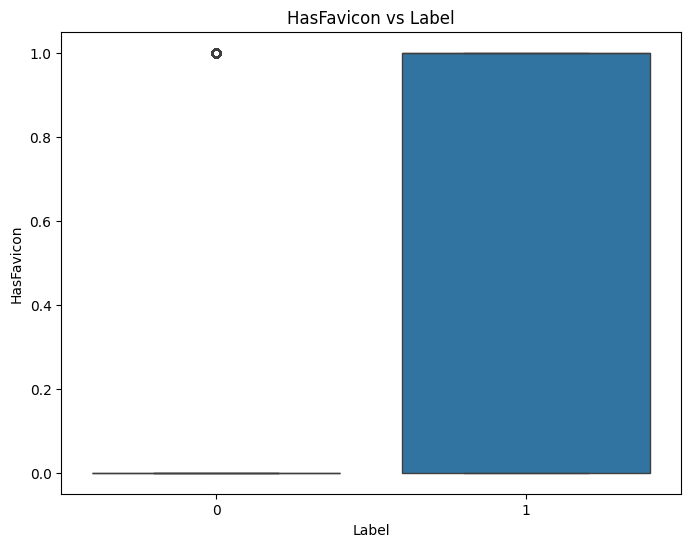

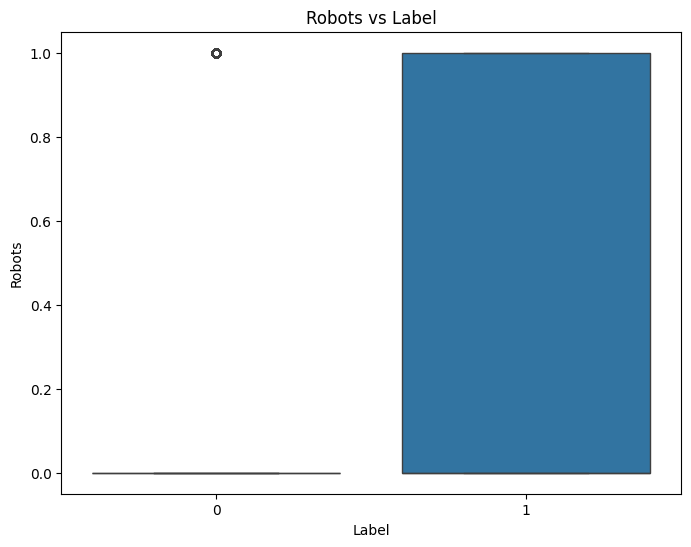

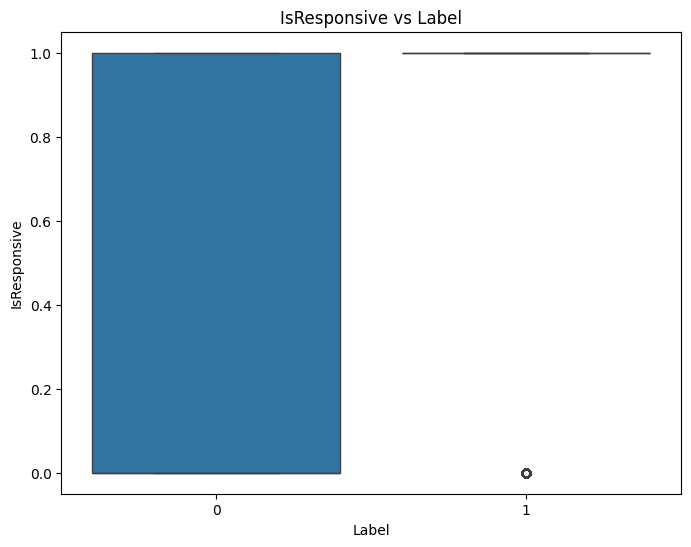

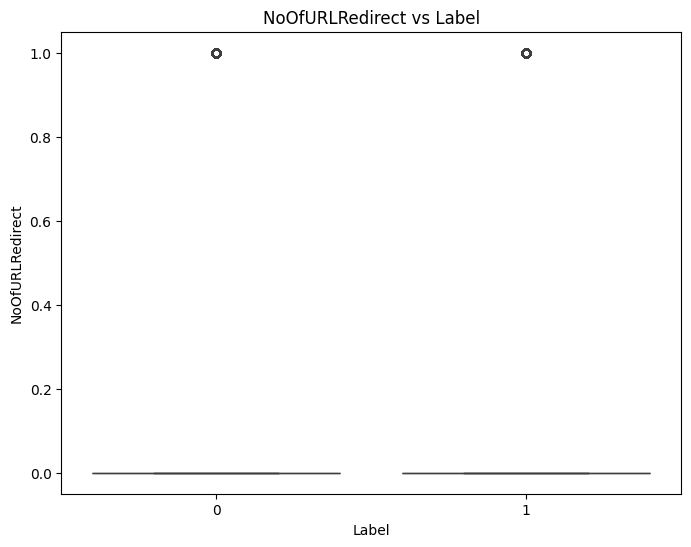

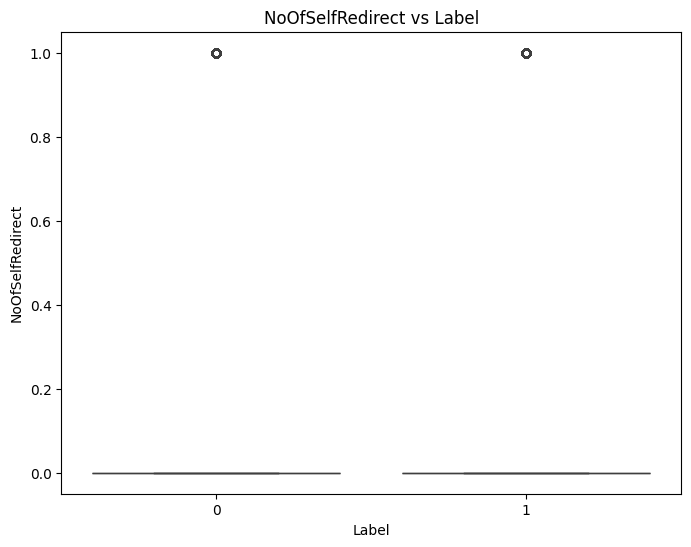

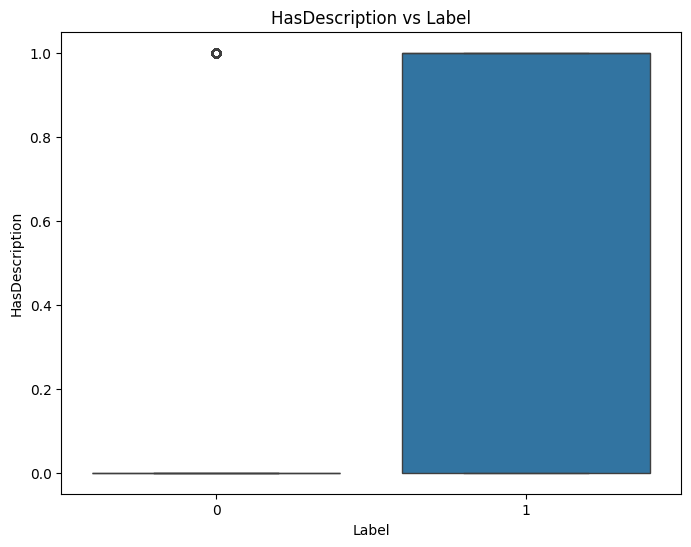

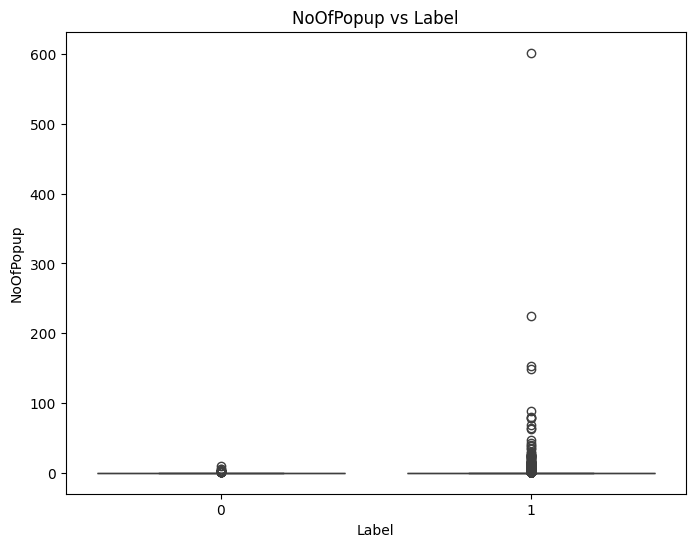

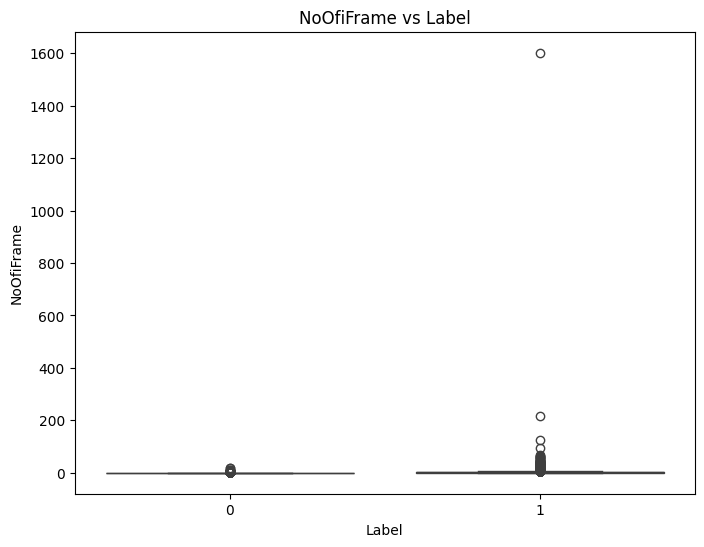

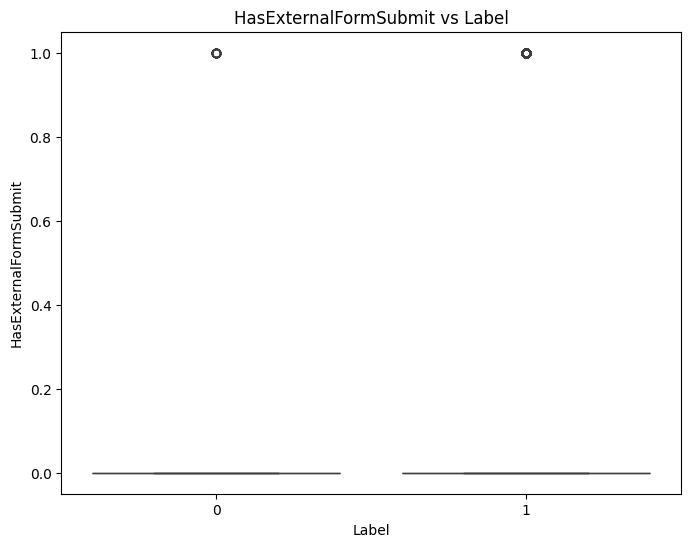

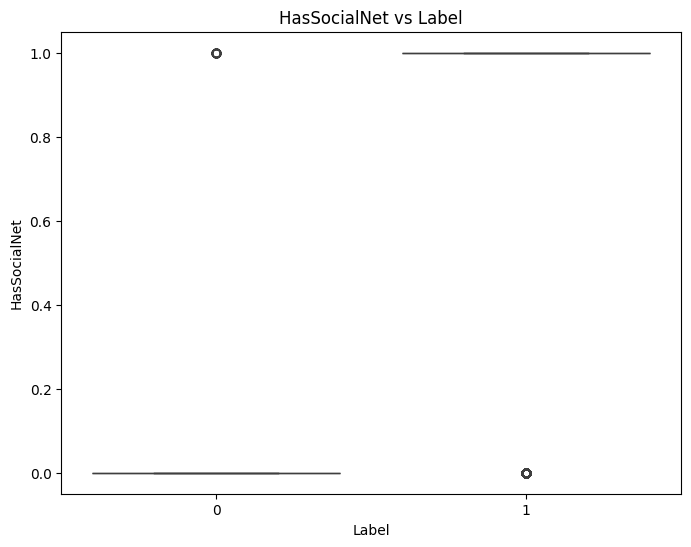

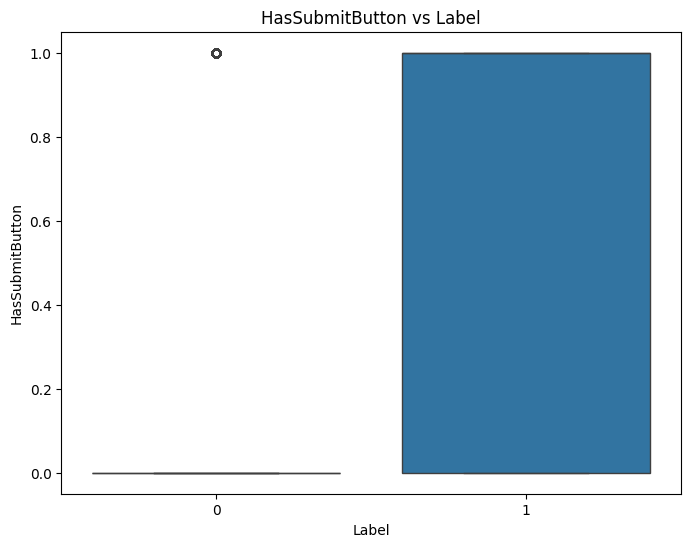

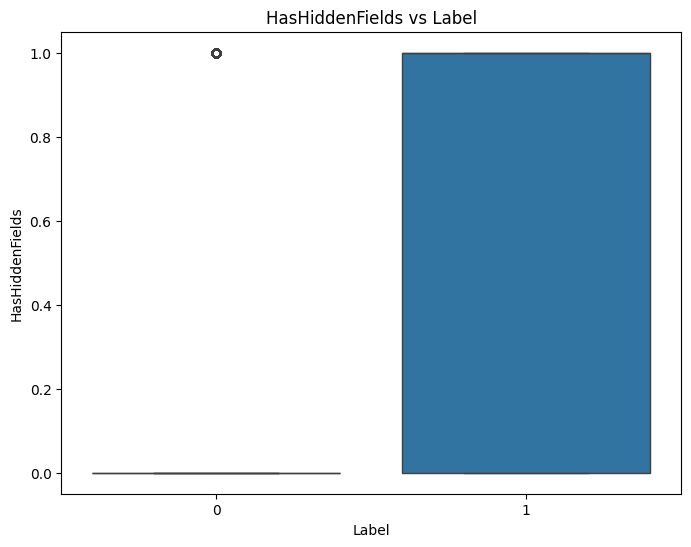

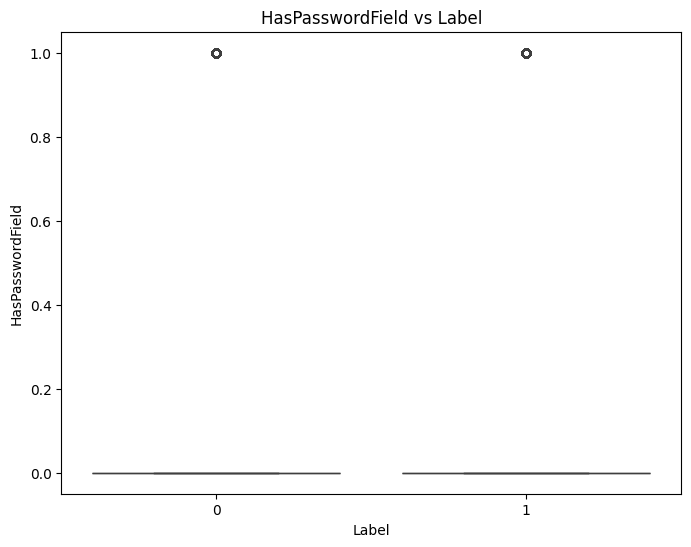

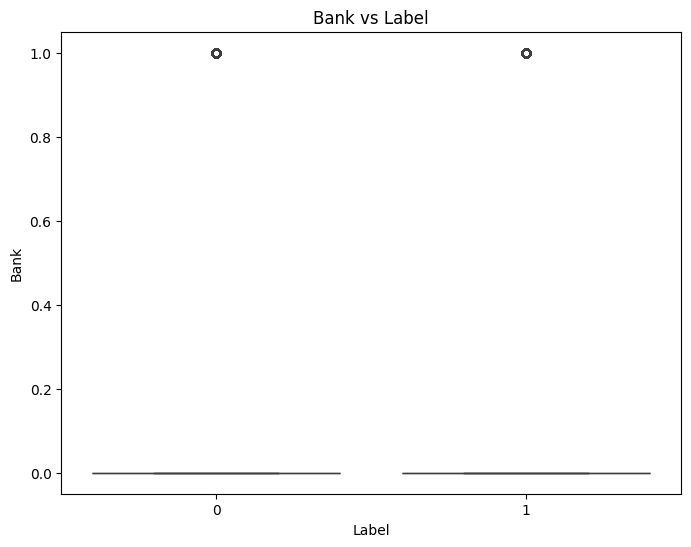

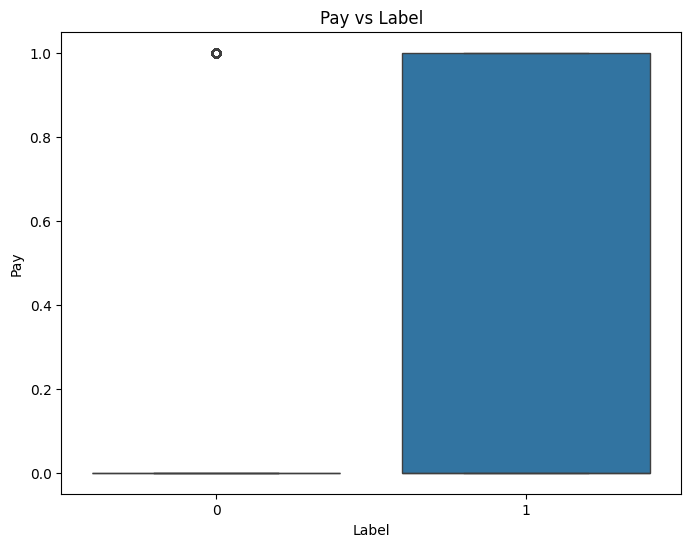

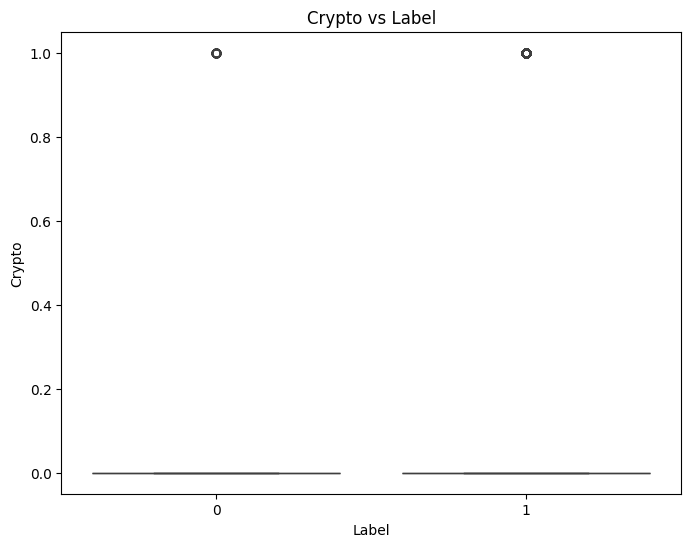

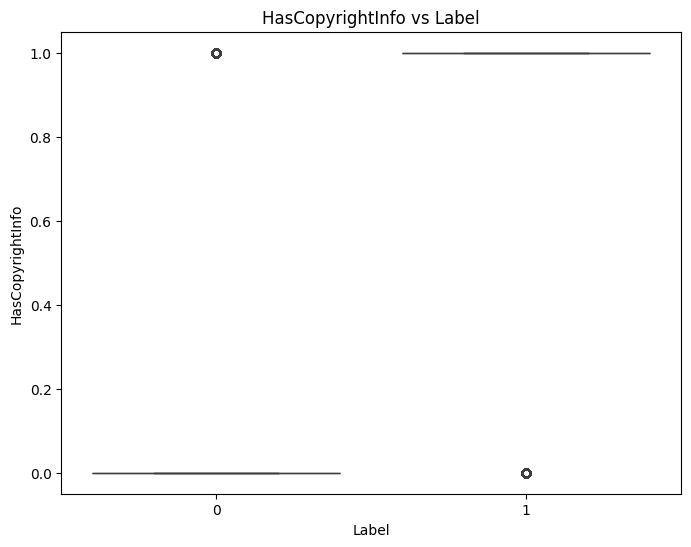

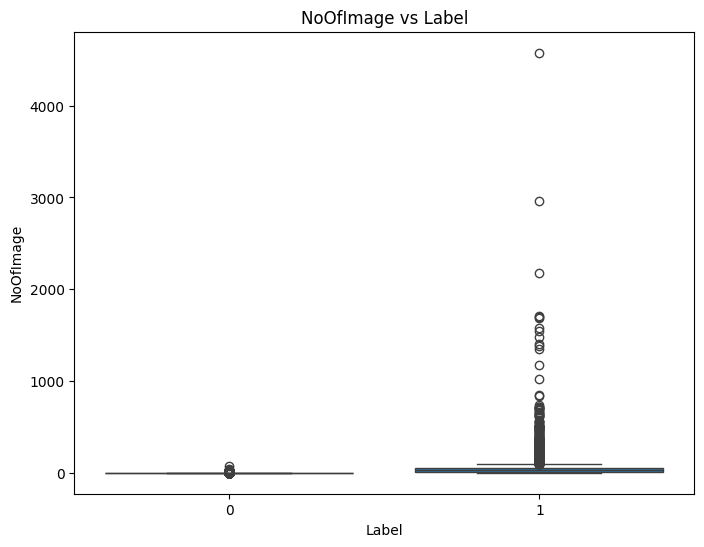

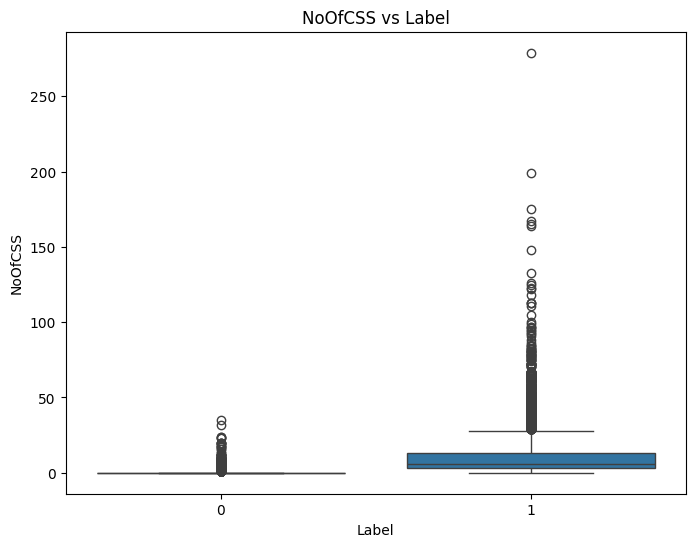

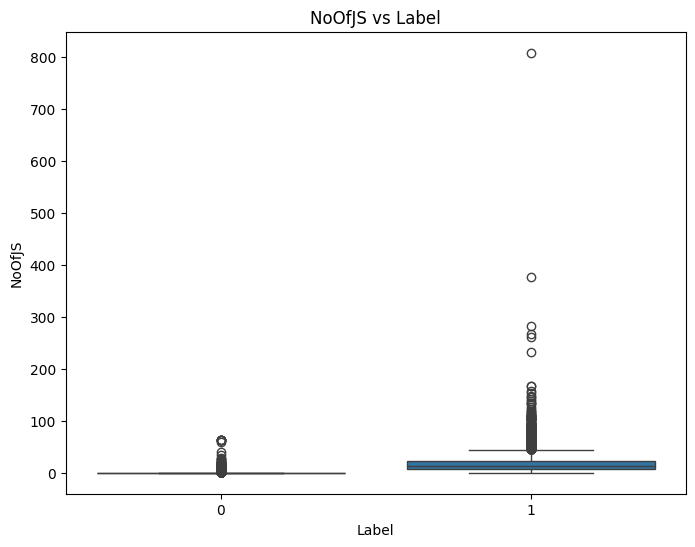

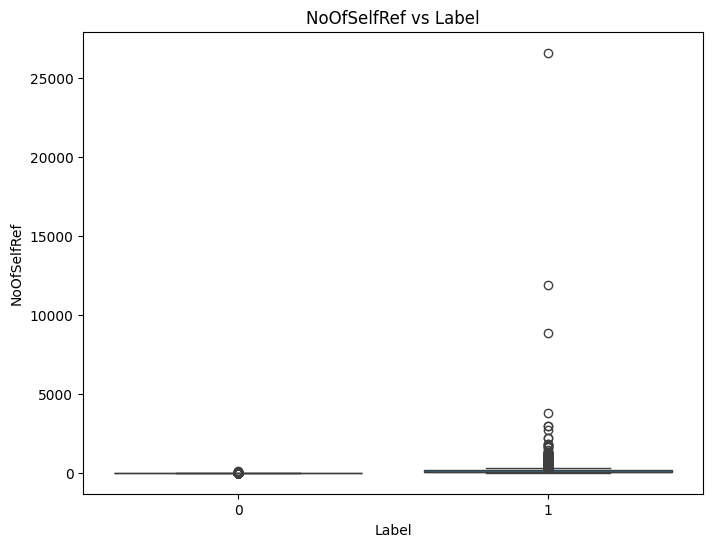

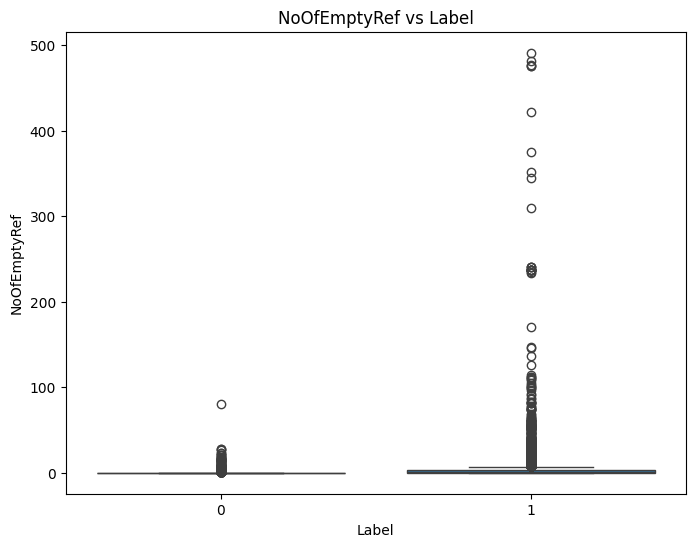

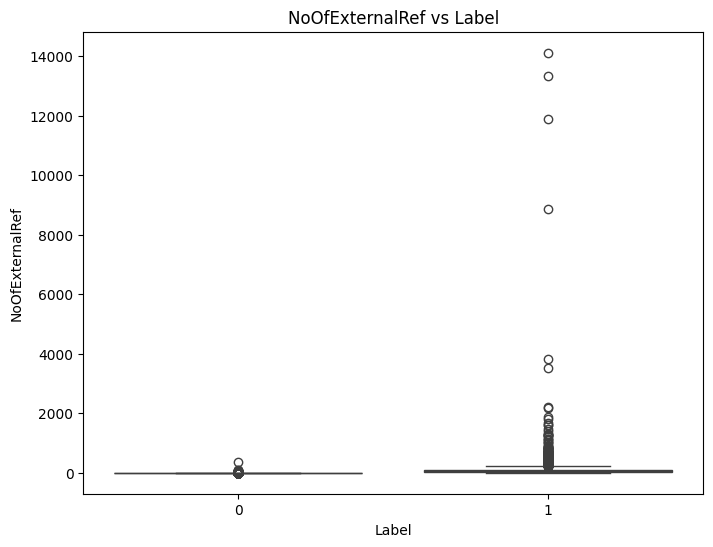

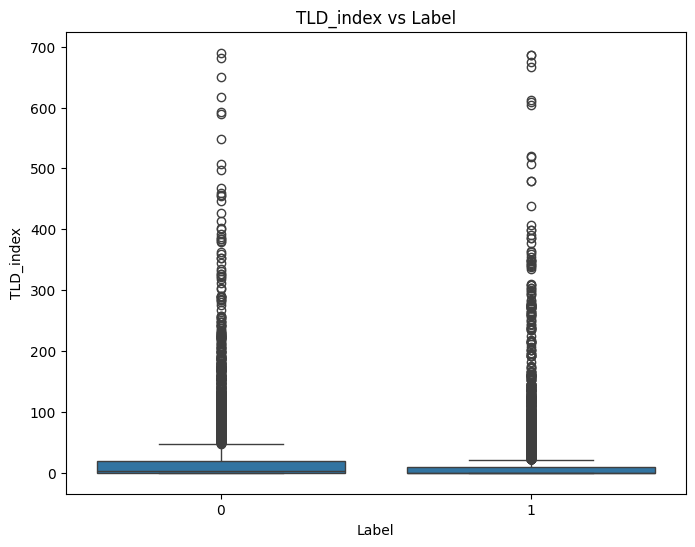

TypeError: Cannot cast Index to dtype <U0

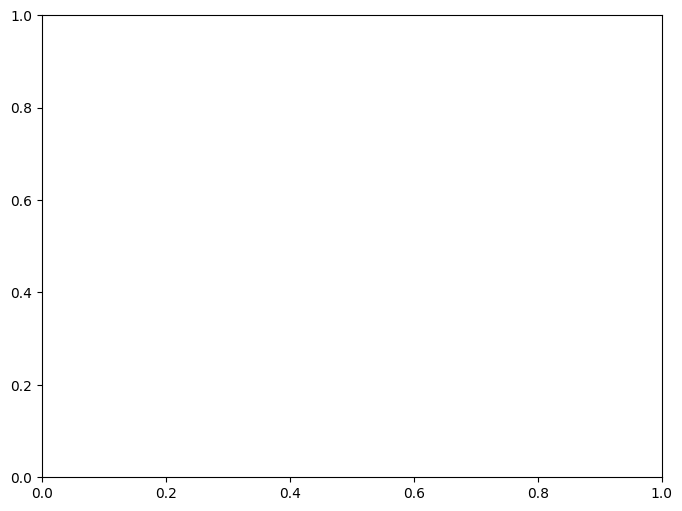

In [23]:


# Plot each column against the label column
for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='label', y=column, data=pandas_df)
    plt.title(f"{column} vs Label")
    plt.xlabel("Label")
    plt.ylabel(column)
    plt.show()


## 3- Model & Training

## 4- Evaluation